In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker
%matplotlib inline

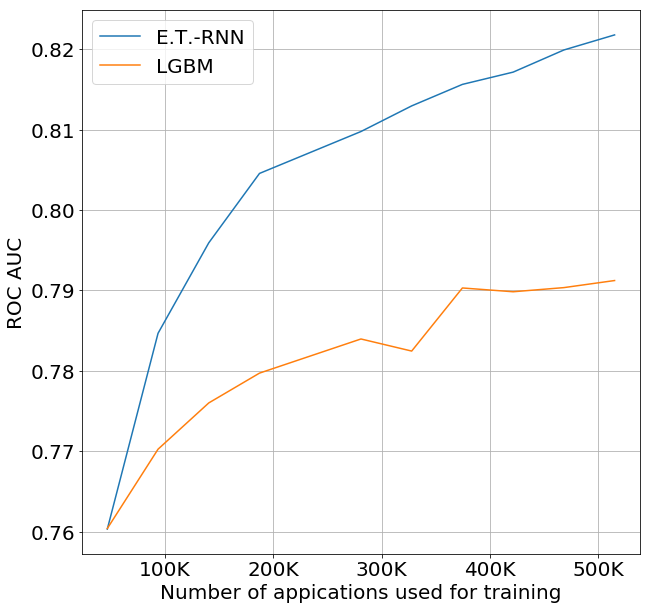

In [34]:
with mpl.rc_context() as rc:
    mpl.rc('font', size=20)
    mpl.rc('savefig', pad_inches=0)

    rnn_lc = pd.read_csv(
        'data/rnn-learning-curve-ens6.csv',
        index_col='n_samples',
        squeeze=True,
        header=None,
        names=['n_samples', 'E.T.-RNN'])
    
    lgbm_lc = pd.read_csv(
        'data/lgbm-learning-curve.csv',
        index_col='n_samples',
        squeeze=True,
        header=None,
        names=['n_samples', 'LGBM'])
    
    lc = pd.DataFrame([rnn_lc, lgbm_lc]).T
    lc.index = lc.index/1000
    ax = lc.plot(figsize=(10,10), grid=True)
    ax.set_ylabel('ROC AUC')
    ax.set_xlabel('Number of appications used for training')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}K"))
    
    mpl.pyplot.savefig('figures/learning-curve.png', bbox_inches='tight')

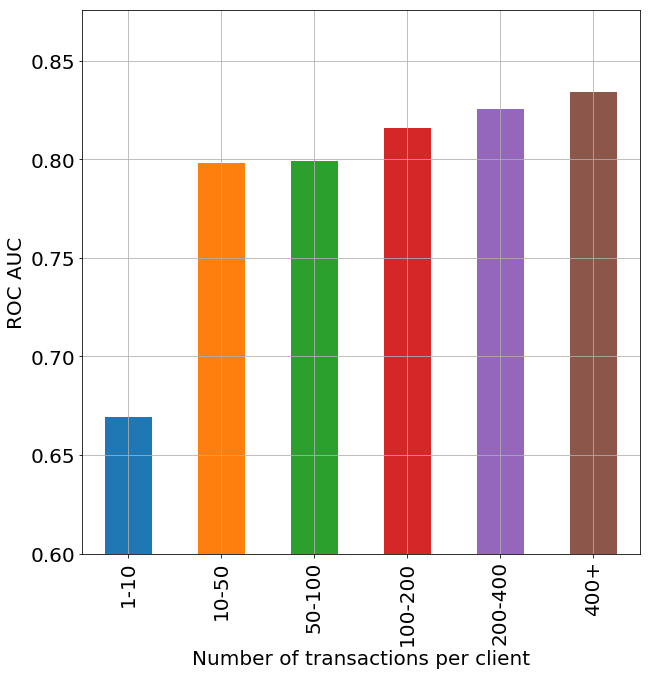

In [67]:
with mpl.rc_context() as rc:
    mpl.rc('font', size=20)

    lc = pd.read_csv('data/rnn-ens6-bins-cutoff.csv')

    new_bins = []
    for s, e in [(0, 10), (10, 50), (50, 100), (100, 200), (200, 400), (400, 1000000000)]:
        bin_q = lc.query(f'cutoff_s >= {s} and cutoff_e <= {e}')
        new_bins.append((s, e, bin_q.roc_auc.mean(), bin_q.share.sum()))
        
    lc = pd.DataFrame(new_bins, columns=['cutoff_s', 'cutoff_e', 'roc_auc', 'share'])
    
    lc['bin'] = lc.cutoff_s.map(str) + '-' + lc.cutoff_e.map(str)
    lc.at[5, 'bin'] = '400+'
    lc.at[0, 'bin'] = '1-10'
    lc.set_index('bin')
    lc = lc.set_index('bin')
    lc['coverage'] = 1 - lc.share

    ax = lc['roc_auc'].plot.bar(figsize=(10,10), grid=True)
    ax.set_ylabel('ROC AUC')
    ax.set_ylim(bottom=.6)
    
    ax.set_xlabel('Number of transactions per client')

    mpl.pyplot.savefig('figures/information-vs-accuracy-bins.png', bbox_inches='tight')

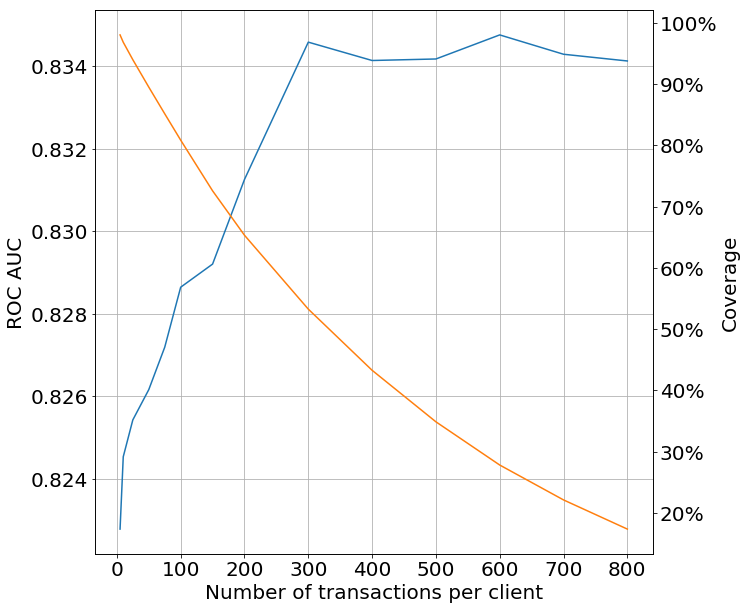

In [10]:
with mpl.rc_context() as rc:
    mpl.rc('font', size=20)

    lc = pd.read_csv('data/rnn-ens6-share-cutoff.csv', index_col='cutoff')
    #lc = lc.drop([400, 500, 600])

    ax = lc['roc_auc'].plot(figsize=(10,10), grid=True)
    ax.set_ylabel('ROC AUC')

    #ax2 = ax.twinx()
    ax2 = lc['share'].plot(ax=ax, figsize=(10,10), secondary_y=True, grid=True)
    ax2.set_ylabel('Coverage')
    ax.set_xlabel('Number of transactions per client')
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.))

    mpl.pyplot.savefig('figures/information-vs-accuracy-max.png', bbox_inches='tight')

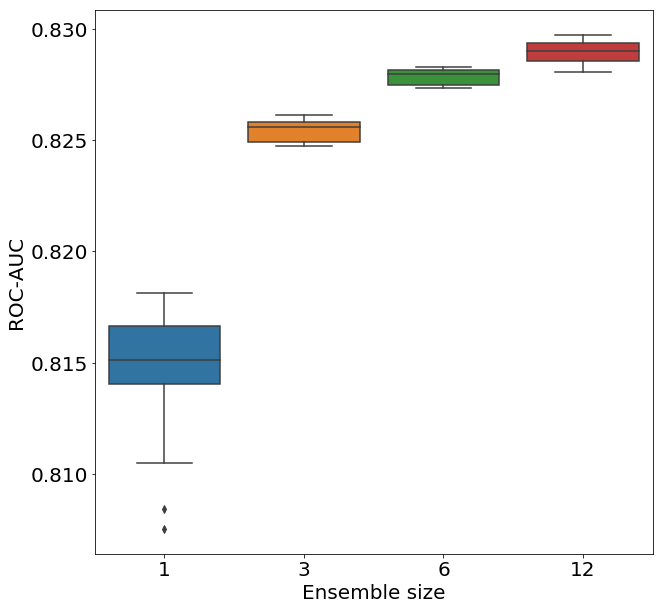

In [15]:
stats_ensemble = pd.read_json('article-stats.json').query('n_epoch == 10 \
and ensemble_size in (1, 3, 6, 12) and rnn_type == \'gru\' and bidir == False and embed_dropout == 0 \
and trx_dropout == 0.01 and permute_trials_proportion == 0 and lr == 0.004 and loss ==\'ranking\' \
and loss_margin == 0.01 and lr_step_gamma == 0.5')

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10,10))
    mpl.rc('font', size=20)
    ax = sns.boxplot(x="ensemble_size", y="ROC-AUC", data = stats_ensemble)
    
    ax.set_xlabel('Ensemble size')
    
    mpl.pyplot.savefig('figures/ensemble-pic.png', bbox_inches='tight')

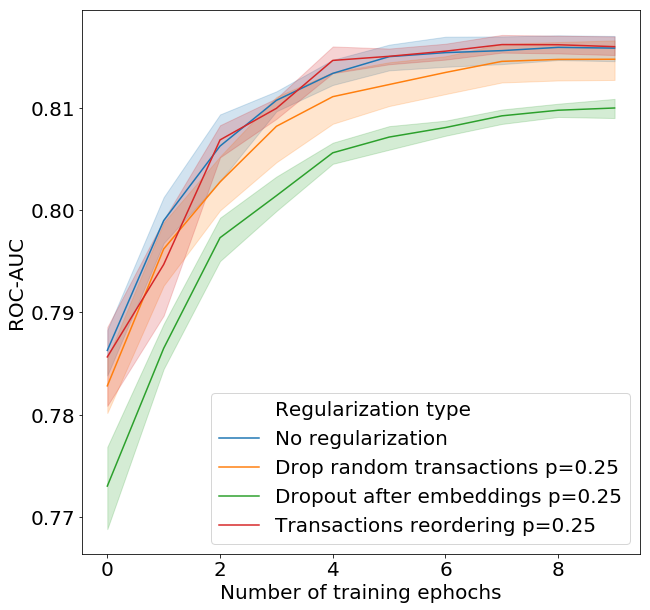

In [75]:
stats_do = pd.read_json('article-stats.json').query('n_epoch == 10 \
and ensemble_size == 1 and rnn_type == \'gru\' and bidir == False and lr_step_gamma == 0.6000000000000001 \
and lr == 0.004 and loss ==\'ranking\' and loss_margin == 0.01')

reg_type_title = 'Regularization type'
stats_do[reg_type_title] = 'No regularization'
stats_do.loc[stats_do['trx_dropout']==0.25, reg_type_title] = 'Drop random transactions p=0.25'
stats_do.loc[stats_do['embed_dropout']==0.25, reg_type_title] = 'Dropout after embeddings p=0.25'
stats_do.loc[stats_do['permute_trials_proportion']==0.25, reg_type_title] = 'Transactions reordering p=0.25'

tl = stats_do.metrics.map(lambda e: e['valid_auc'])
tl_es = [(i, e, es) for l, es in zip(tl.tolist(), stats_do[reg_type_title]) for i, e in enumerate(l)]
tl_df = pd.DataFrame(tl_es, columns=['epoch', 'ROC-AUC', reg_type_title])

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10,10))
    mpl.rc('font', size=20)
    ax = sns.lineplot(x="epoch", y="ROC-AUC", data=tl_df, hue=reg_type_title, legend="full")
    ax.set_xlabel('Number of training ephochs')
    
    mpl.pyplot.savefig('figures/do-pic.png', bbox_inches='tight')

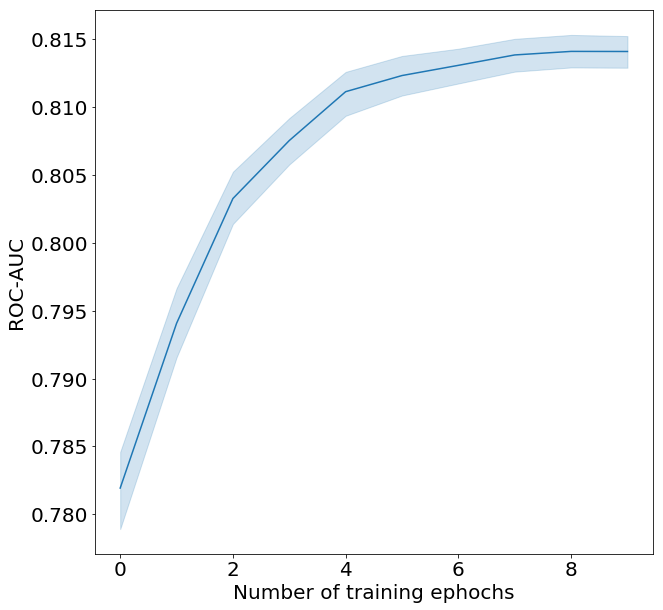

In [17]:
stats_do = pd.read_json('article-stats.json').query('n_epoch == 10 \
and ensemble_size == 1 and rnn_type == \'gru\' and bidir == False and lr_step_gamma == 0.6000000000000001 \
and lr == 0.004 and loss ==\'ranking\' and loss_margin == 0.01')

stats_do['reg_type'] = 'no regularization'
tl = stats_do.metrics.map(lambda e: e['valid_auc'])
tl_es = [(i, e, es) for l, es in zip(tl.tolist(), stats_do.reg_type) for i, e in enumerate(l)]
tl_df = pd.DataFrame(tl_es, columns=['epoch', 'ROC-AUC', 'reg_type'])

with mpl.rc_context() as rc:
    mpl.rc("figure", figsize=(10,10))
    mpl.rc('font', size=20)
    ax = sns.lineplot(x="epoch", y="ROC-AUC", data=tl_df, hue="reg_type", legend=None)
    ax.set_xlabel('Number of training ephochs')
    
    mpl.pyplot.savefig('figures/latent-pic.png', bbox_inches='tight')